<a href="https://colab.research.google.com/github/ucaokylong/poem_generator_2/blob/main/Poem7_generator_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Tải bộ dữ liệu**
**Lưu ý:** Nếu không thể tải bằng gdown do bị giới hạn số lượt tải, các bạn hãy tải thủ công và đưa lên drive của mình, sau đó copy từ drive vào colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive 

Mounted at /content/drive
cp: missing destination file operand after '/path/to/dataset/on/your/drive'
Try 'cp --help' for more information.


In [ ]:
# https://drive.google.com/file/d/1DlJY6ySqSZZEUgiOqL2uCkKagt5bP3MN/view?usp=share_link
!gdown --id 1c066fEbDP5ZMDJhukYhFRITnu4ZZcLxb

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1c066fEbDP5ZMDJhukYhFRITnu4ZZcLxb 



In [ ]:
!unzip '/content/drive/MyDrive/AI_project/poem7_dataset.zip'

Archive:  /content/drive/MyDrive/AI_project/poem7_dataset.zip
  inflating: poem7_dataset.csv       


## **1. Import các thư viện cần thiết**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

## **2. Chuẩn bị dữ liệu**

In [ ]:
def text_normalize(text):
    text = text.lower()
    text = text.strip() 
    text = re.sub(r'[^\w\s\n]', '', text)
    text = text.replace('\n\n', '\n')
    text = '\n'.join(['<start> ' + line + ' <end>' for line in text.split('\n') if line != '' and len(line.split()) == 7  ])
 
    return text

In [ ]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 9
VOCAB_SIZE = 5000 

In [ ]:
DATASET_PATH = './poem7_dataset.csv'

df = pd.read_csv(DATASET_PATH, index_col=0)
df['content'] = df['content'].apply(lambda p: text_normalize(p))
corpus = df['content'].to_numpy()

X = []
y = []
for idx, row in df.iterrows():
    lines = row['content'].split('\n')
    lines = [line for line in lines if line != '']
    for idx in range(0, len(lines) - 1):
        input_sentence = lines[idx]
        output_sentence = lines[idx+1]

        X.append(input_sentence)
        y.append(output_sentence)

In [ ]:
for idx in range(len(X))[:30]:
    print(f'Input: {X[idx]} => {y[idx]}')

Input: <start> bên đường xe tang buồn đi qua <end> => <start> chiều hôm mồ hoang sương trăng tà <end>
Input: <start> chiều hôm mồ hoang sương trăng tà <end> => <start> vô thường đời trần thương ôi mau <end>
Input: <start> vô thường đời trần thương ôi mau <end> => <start> người đi rồi lần sang phiên ta <end>
Input: <start> người đi rồi lần sang phiên ta <end> => <start> nghìn xưa xa vời trong mông lung <end>
Input: <start> nghìn xưa xa vời trong mông lung <end> => <start> tài hoa tan về nơi vô cùng <end>
Input: <start> tài hoa tan về nơi vô cùng <end> => <start> luân hồi không cầu đường siêu thăng <end>
Input: <start> luân hồi không cầu đường siêu thăng <end> => <start> dù cho hiền minh sao anh hùng <end>
Input: <start> dù cho hiền minh sao anh hùng <end> => <start> hoàng hôn mây hồng in non xa <end>
Input: <start> hoàng hôn mây hồng in non xa <end> => <start> dung hoa thầm khô theo suy già <end>
Input: <start> dung hoa thầm khô theo suy già <end> => <start> di đà chuyên tu phòng lâm ch

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='', oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
def prepare_output_sequences(y_sequences):
    y_inputs = pad_sequences([y_seq[:-1] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')
    y_outputs = pad_sequences([y_seq[1:] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

    return y_inputs, y_outputs

X_sequences = tokenizer.texts_to_sequences(X)
X_padded_sequences = pad_sequences(X_sequences, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

y_sequences = tokenizer.texts_to_sequences(y)
y_inputs, y_outputs = prepare_output_sequences(y_sequences)

In [ ]:
n_samples = len(X_padded_sequences)
train_len = int(n_samples * 0.7)
val_len = int(n_samples * 0.2)
test_len = n_samples - train_len - val_len

# Shuffle 
np.random.seed(1)
idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X_padded_sequences = X_padded_sequences[idxs]
y_inputs = y_inputs[idxs]
y_outputs = y_outputs[idxs]

# Split the data into train, validation, and test sets
X_train_seq, y_train_input, y_train_output = X_padded_sequences[:train_len], y_inputs[:train_len], y_outputs[:train_len]
X_val_seq, y_val_input, y_val_output = X_padded_sequences[train_len:train_len+val_len], y_inputs[train_len:train_len+val_len], y_outputs[train_len:train_len+val_len]
X_test_seq, y_test_input, y_test_output = X_padded_sequences[train_len+val_len:], y_inputs[train_len+val_len:], y_outputs[train_len+val_len:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_seq, y_train_input), y_train_output)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_seq, y_val_input), y_val_output)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_seq, y_test_input), y_test_output)).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

### 3.1. Positional Encoding Layer

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

### 3.2. Self-attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

### 3.3. Cross-attention Layer

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

### 3.4. Global Self-attention Layer

In [ ]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

### 3.5. Causal Self-attention Layer

In [ ]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

### 3.6. Feed-forward Network

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

### 3.7. Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

### 3.8. Transformer Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

### 3.9. Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

### 3.10. Transformer Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

### 3.11. Transformer Model

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [ ]:
N_LAYERS = 4
D_MODEL = 128
D_FF = 512
N_HEADS = 8
DROPOUT_RATE = 0.2

In [ ]:
transformer = Transformer(
    num_layers=N_LAYERS,
    d_model=D_MODEL,
    num_heads=N_HEADS,
    dff=D_FF,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT_RATE
)

In [ ]:
batches = train_ds.take(1)
for batch in batches:
    X_try, y_try = batch[0], batch[1]
    

In [ ]:
output = transformer(X_try)

In [ ]:
output.shape

TensorShape([32, 9, 357])

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2684544   
                                                                 
 decoder (Decoder)           multiple                  4795520   
                                                                 
 dense_16 (Dense)            multiple                  46053     
                                                                 
Total params: 7,526,117
Trainable params: 7,526,117
Non-trainable params: 0
_________________________________________________________________


## **4. Cấu hình mô hình**

In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 60

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98,
    epsilon=1e-9
)

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def compute_perplexity(logits, targets):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_fn(targets, logits)

    perplexity = np.exp(np.mean(loss))

    return perplexity


def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        predicted_strings.append(string_seq)
    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        target_strings.append([string_seq])  

    bleu_score = corpus_bleu(target_strings, predicted_strings)

    return bleu_score

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

## **5. Thực hiện huấn luyện**

In [ ]:
history = transformer.fit(
    train_ds,
    epochs=200,
    validation_data=val_ds
)

Epoch 1/200
2/2 [==============================] - 0s 250ms/step - loss: 4.9109 - masked_accuracy: 0.1615 - val_loss: 5.2887 - val_masked_accuracy: 0.1406
Epoch 2/200
2/2 [==============================] - 0s 166ms/step - loss: 4.8871 - masked_accuracy: 0.1719 - val_loss: 5.2837 - val_masked_accuracy: 0.1406
Epoch 3/200
2/2 [==============================] - 0s 136ms/step - loss: 4.8543 - masked_accuracy: 0.1582 - val_loss: 5.2807 - val_masked_accuracy: 0.1406
Epoch 4/200
2/2 [==============================] - 0s 235ms/step - loss: 4.8612 - masked_accuracy: 0.1582 - val_loss: 5.2794 - val_masked_accuracy: 0.1406
Epoch 5/200
2/2 [==============================] - 0s 151ms/step - loss: 4.8156 - masked_accuracy: 0.1641 - val_loss: 5.2767 - val_masked_accuracy: 0.1406
Epoch 6/200
2/2 [==============================] - 0s 253ms/step - loss: 4.7828 - masked_accuracy: 0.1595 - val_loss: 5.2732 - val_masked_accuracy: 0.1406
Epoch 7/200
2/2 [==============================] - 0s 134ms/step - los

## **6. Đánh giá và trực quan hóa**

In [ ]:
# Đánh giá mô hình trên tập test
test_evaluation = transformer.evaluate(test_ds)

1/1 [==============================] - 0s 35ms/step - loss: 5.9656 - masked_accuracy: 0.1528


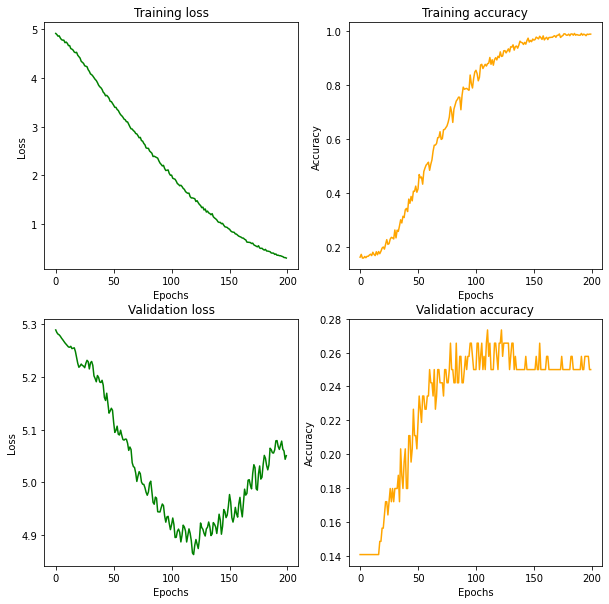

In [ ]:
# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='green') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='green') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

In [ ]:
perplexities = []
bleu_scores = []
for sample in val_ds.take(1):
    X_try, y_try = sample
    y_pred = transformer(X_try)
    batch_perplexity = compute_perplexity(y_pred, y_try)
    batch_bleu_score = compute_bleu(y_pred, y_try)

    perplexities.append(batch_perplexity)
    bleu_scores.append(batch_bleu_score)

    # print(f'Perplexity: {batch_perplexity}')
    # print(f'BLEU score: {batch_bleu_score}')

print(f'Perplexity: {sum(perplexities) / len(perplexities)}')
print(f'BLEU score: {sum(bleu_scores) / len(bleu_scores)}')

Perplexity: 247.0969696044922
BLEU score: 0.310542000227056


## **7. Inference**

In [ ]:
def generate_text(
    generator_model, 
    tokenizer,
    input_string
    ):
    
    encoder_input_string = text_normalize(input_string) 
    encoder_input_sequence = tokenizer.texts_to_sequences([encoder_input_string])
    encoder_input_padded_sequence = pad_sequences(encoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    encoder_input_padded_sequence = np.expand_dims(encoder_input_padded_sequence, axis=0)

    decoder_input_string = '<start>'
    decoder_input_sequence = tokenizer.texts_to_sequences([decoder_input_string])
    decoder_input_padded_sequence = pad_sequences(decoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    start = decoder_input_padded_sequence[0][tf.newaxis]
    end = decoder_input_padded_sequence[1][tf.newaxis]
    decoder_input_padded_sequence = np.expand_dims(decoder_input_padded_sequence, axis=0)

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(MAX_SEQ_LEN):
        output = tf.transpose(output_array.stack())
        predictions = generator_model((encoder_input_padded_sequence, output), training=False)

        # Select the last token from the `seq_len` dimension.
        predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

        predicted_id = tf.argmax(predictions, axis=-1)

        # Concatenate the `predicted_id` to the output which is given to the
        # decoder as its input.
        output_array = output_array.write(i+1, predicted_id[0])

        if predicted_id == end:
            break

    output = tf.transpose(output_array.stack())
    output_tokens = output.numpy()
    # The output shape is `(1, tokens)`.
    text = tokenizer.sequences_to_texts(output_tokens)[0]  # Shape: `()`.


    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    generator_model([decoder_input_padded_sequence, output[:, :-1]], training=False)
    attention_weights = generator_model.decoder.last_attn_scores

    return text, output_tokens, attention_weights

In [ ]:
n_sentences = 7
results = ['Đêm nhớ nhà trầm tư uất hận']
for idx in range(n_sentences + 1):
    input_str = results[idx]
    text, output_tokens, attention_weights = generate_text(
        transformer, 
        tokenizer,
        input_str
    )
    results.append(text.replace('<start>', '').replace('<end>', ''))

print('\n'.join(results))

Đêm nhớ nhà trầm tư uất hận
 tương tư mơ về trời liên hoa  
 dặm ngàn liễu khuất với sương che  
 yêu anh trả dứt nợ đời sau  
 em bước vào lao đao nhịp guốc  
 vẫn chưa ra khỏi giấc chiêm bao  
 hãy giẫm đời nhau cho hoang phế  
 cho một lần em biết đớn đau  
 anh đã trót hư hao lãng phí  


In [ ]:
transformer.save_weights('lam_tho_7chu.h5')
